## Dark frame analyses, part 1: searching for 1/f noise 
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: Jan 27, 2021

### Introduction

This notebook is intended to reproduce Figure 4 on  <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160..231S/abstract">Schlawin et al. (2020)</a>, namely, the (average) power spectral density of amplifier 2 in the NIRCam detector using the `RAPID` readout mode. Everett Schlawin has been kind enough to share the same dark data they used on their paper, so we could have a look at it and reproduce the results. The motivation for us doing it has to do with some JWST Time-Series Observations Working Group work we are doing at STScI, but it might be illustrative to other folks doing similar analyses in other contexts as well. 

It is important to note that Everett had his own set of codes to do a similar analysis <a href="https://github.com/eas342/simple_1_over_f_investigation">here</a> and <a href="https://github.com/eas342/pixeltime">here</a> --- but I found out about those codes later in the writing of this notebook (when comparing notes with him --- which was very useful!). Nonetheless, I think this notebook might be a straightforward illustrative example of how to perform these kind of analyses.

All right, let's start by loading some libraries:

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from IPython.display import HTML

from astropy.stats import LombScargle
from astropy.io import fits

# This library helps making animated images:
from celluloid import Camera

### 1. Initial checks and pre-processing

Let's extract all the filenames for NIRCam groups (courtesy of Everett Schlawin!):

In [2]:
files = glob.glob('data/*.fits')

For pure double-checking purposes, check the very first file `fits` info:

In [3]:
d = fits.open(files[0])
print(d.info())

Filename: data/NRCNRCALONG-DARK-72350742131_1_485_SE_2017-08-23T16h49m51.red_grp_0106.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1493   (2048, 2048)   float32   
None


All right, dimension is `(2048 x 2048)`. Remember that this is a 4-amplifier detector; we'll deal with all of them first, and then just work with amplifier 2, which is the one on the paper. 

Let's load all the images into a cube --- making sure to substract the median flux of each group (in case they have group-to-group flux variations by, e.g., overall temperature fluctuations perhaps?):

In [4]:
# Define data cube that will store the images. First dimension is the number of groups (files), 
# second and third are the spatial dimensions of the image:
data_cube = np.zeros([len(files), 2048, 2048])

# Iterate through all of them; load them, and substract the median flux from the entire image 
# to remove group-to-group overall flux variations:
for i in range(len(files)):
    d = fits.open(files[i])
    data_cube[i, :, :] = d['PRIMARY'].data - np.median(d['PRIMARY'].data)

Now, let's calculate the median of all groups and substract that to each group following <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160..231S/abstract">Schlawin et al. (2020)</a>. This effectively should remove the bias variations _accross_ the image which are common to all groups. 

First, calculate (and plot) group median:

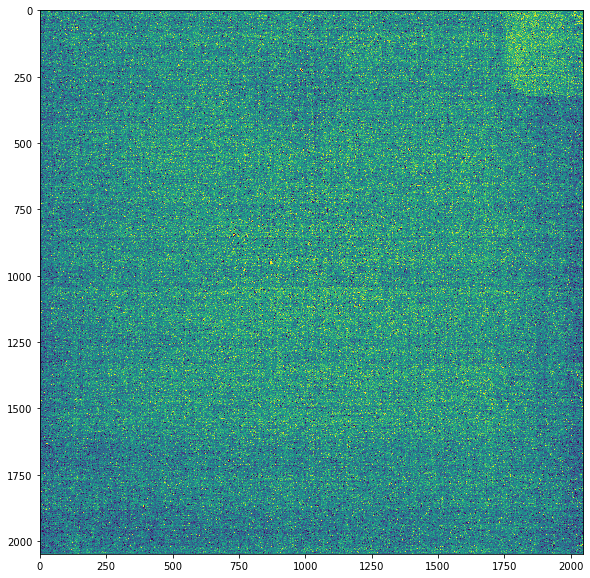

In [5]:
# Take median of all groups:
group_median = np.median(data_cube, axis=0)

# Plot it:
plt.figure(figsize=(10,10))

im = plt.imshow(group_median)
im.set_clim(-100,100)

Now let's remove this group median from each group:

In [6]:
for i in range(data_cube.shape[0]):
    data_cube[i, :, :] -= group_median

All right, let's plot a handful of groups to to check how they look like, and if we can spot some 1/f fluctuations:

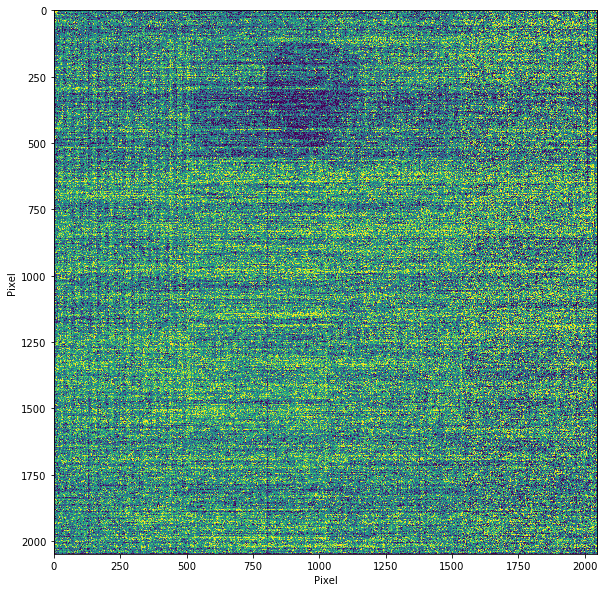

In [7]:
fig = plt.figure(figsize=(10,10))

# Create animation:
camera = Camera(fig)

# Iterate through all groups:
for ngroup in range(data_cube.shape[0]):
    im = plt.imshow(data_cube[ngroup, :, :] - np.median(data_cube[ngroup, :, :]))
    im.set_clim(-10,10)
    plt.xlabel('Pixel')
    plt.ylabel('Pixel')
    camera.snap()

In [8]:
anim = camera.animate()
HTML(anim.to_html5_video())

Awesome! Pretty evident. Some seem a bit weird (with a "head"-like figure at the top) but most are pretty similar to the ones shown on Figure 4 of Everett's paper. In any case, we'll take care of weird patterns later, when we do some "outlier" rejection just like in Everett's paper. 

In Figure 4 of Everett's paper, they did a close-up to columns 300 to 800 and rows 300 to 800. Let's do the same close-up:

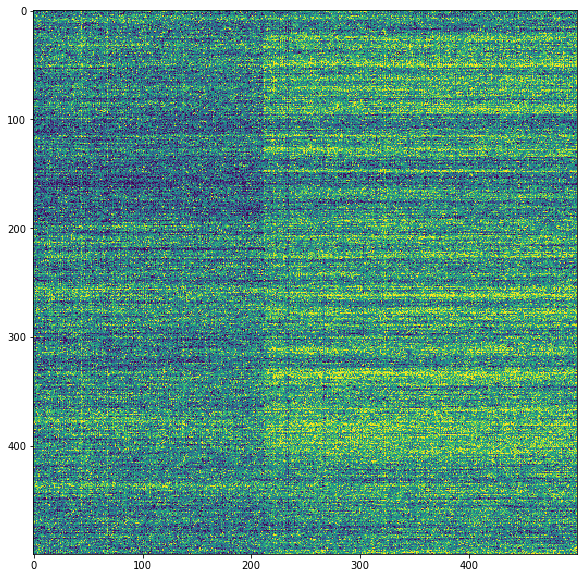

In [9]:
plt.figure(figsize=(10,10))
im = plt.imshow(data_cube[4, 300:800, 300:800])
im.set_clim(-10,10)

That looks good! We can even see by eye the amplifier gap at around 212 (note the image starts from column/row zero, but this is a cut from column 300 to 800 --- so physical units of column 212 above are really 212 + 300 = 512, exactly where we expect the amplifier gap according to Everett's papeR). Let's now move to the next step of actually computing the Power Spectral Densities.

### 2. Computing power spectral densities

OK, now we know we have the 1/f patterns. Let's follow <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160..231S/abstract">Schlawin et al. (2020)</a>, and compute the power spectral density (PSD) of the fluxes on these integrations. 

To this end, we perform the analysis on Amplifier 2 only, which goes from $X=512$ to $X=1024$:

In [10]:
amp2 = data_cube[:,:,512:1024]

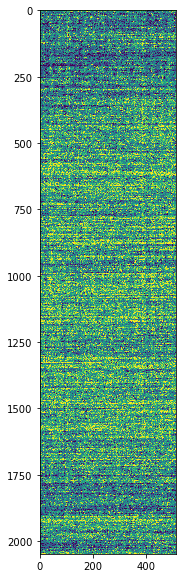

In [11]:
plt.figure(figsize=(10,10))

im = plt.imshow(amp2[1,:,:])
im.set_clim(-10,10)

Let's now convert this from spatial flux values into a time-series of fluxes. To this end, we consider the same time-scales assumed in Everett's paper; namely, that each pixel is read in 10$\mu$s, and that to jump to the next row takes 120$\mu$s. Let's work with the second group in our dataset to get an idea of how this will work.

First, we note that care has to be taken in deciding where to start counting pixels and _in which direction_. From Figure 1 in Everett's paper, the scheme of the detector reads is as follows:

<img src="nircam_detector.png" width="400" height="200"></img>

We are interested in analyzing amplifier 2, whose reading of pixels goes from _right to left_. This is important, because remember we want to follow _as closely as possible_ what the detector electronics are doing when reading pixels. What we will do in our analysis below, thus, is to start counting from the top right pixel, going to the left, all the way down to the bottom left pixel in the image above, remembering to (a) consider 10 microseconds of time to read each individual pixel and (b) add 120 microseconds when jumping through each row, i.e.:

<img src="image_direction.png" width="200" height="100"></img>

Let's work with the actual images, to make the process even clearer. To make it as transparent as possible, we will fill each of the fluxes obtained by the readout detector electronics (what I call the `flattened group` below) manually (there are of course pythonic ways of doing this --- but this illustrates the process much better); let's also count the times to create the time-array (i.e., the time associated with each flux read by the detector readout electronics), saving that in a `times` array. Of course, these arrays will have length 2048 x 512 = 1,048,576 (that's a _long_ array!):

In [12]:
# Work with second group:
group = amp2[1,:,:]
rows, cols = group.shape[0], group.shape[1]

# Prepare times and data arrays:
times = np.zeros(rows*cols) 
flattened_group = np.zeros(rows*cols)

ct = 0
counter = 0
for i in range(rows):
    # We sample fluxes from right to left --- to follow the readout direction. 
    # See, e.g., Figure 1: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-readout
    for j in range(cols-1,-1,-1):
        flattened_group[counter] = group[i,j]
        times[counter] = ct
        ct += 10
        counter += 1
    ct += 120

In [13]:
group.shape

(2048, 512)

In [14]:
len(times)

1048576

Let's plot this time-series (we do a little close-up --- otherwise, it is basically impossible to see anything):

Text(0, 0.5, 'Flux (DN)')

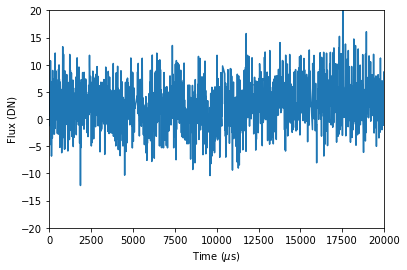

In [15]:
plt.plot(times,flattened_group)
plt.xlim(0,20000)
plt.ylim(-20,20)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Flux (DN)')

Just to see if we _actually_ did what we wanted to do, let's check if there is a gap in time close to pixel 513:

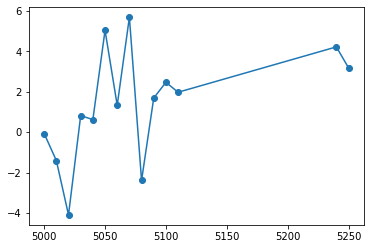

In [16]:
plt.plot(times[500:514],flattened_group[500:514],'o-')

Indeed --- separated by the 120$\mu$s, as we wanted. What about the next cycle?

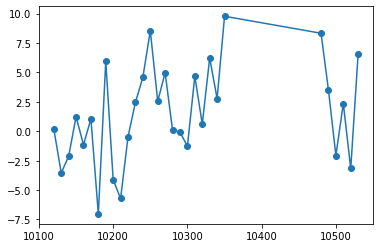

In [17]:
plt.plot(times[1000:1030],flattened_group[1000:1030],'o-')

Same! All is good then; the code did what we wanted.

There's evident correlation between the flux values --- definitely non-white, poissonian/gaussian noise! Let's calculate the power spectral density of this time-series, making sure to mask all pixels with absolute values larger than 80. This latter cut is what Everett did in his paper to remove outlier flux values (like the "head" shape we saw at the beggining of this Notebook), and we repeat it here --- but note this count value might be different in other instruments, so has to be investigated on a case-by-case basis. Below I repeat the same calculation using a "robust" outlier detection scheme which might be more generic than this "80 count" cut and got the same results. I repeat the "80 count" cut here to be consistent with Everett's paper:

In [18]:
good_values = np.where(np.abs(flattened_group)<=80.)[0]
print(len(good_values))
frequency, power = LombScargle(times[good_values]*1e-6, flattened_group[good_values]).autopower()

1047328


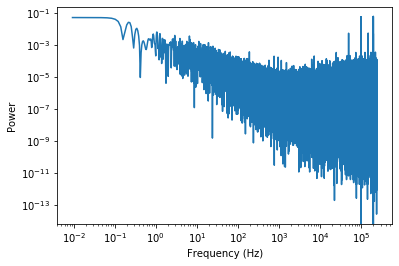

In [19]:
plt.plot(frequency, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')

The slope is evident in the periodogram! However, it is too noisy. Let's thus repeat the same thing for all the other groups, stack the periodograms, plotting the average one. To this end, let's first extract the fluxes on all the groups: 

In [20]:
flattened_groups = np.zeros([108, len(flattened_group)])

In [21]:
for n in range(amp2.shape[0]):
    group = amp2[n,:,:]
    counter = 0
    for i in range(rows):
        for j in range(cols-1,-1,-1):
            flattened_groups[n,counter] = group[i,j]
            counter += 1

Now let's define a common frequency grid. The one below is, in fact, the very same used by Everett on his paper:

In [22]:
new_frequency = np.linspace(1./5.,1./2e-5,65536)

Now let's compute the periodogram of each group; once again, masking only "good" pixels as deemed by that study as values smaller than 80 counts:

In [23]:
powers = np.zeros([amp2.shape[0], len(new_frequency)])
for n in range(amp2.shape[0]):
    good_values = np.where(np.abs(flattened_groups[n,:])<=80.)[0]
    powers[n,:] = LombScargle(times[good_values]*1e-6, flattened_groups[n,good_values]).power(new_frequency)

Let's plot all on top of each other first, for pure fun:

(5e-08, 0.05)

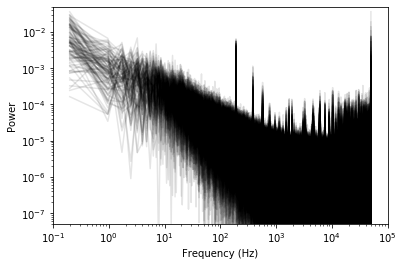

In [24]:
for n in range(amp2.shape[0]):
    plt.plot(new_frequency, powers[n,:],zorder=1,alpha=0.1,color='black')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1,1e5)
plt.ylim(0.5*1e-7,0.5*1e-1)

All right, finally, let's collapse all the lomb-scargle periodograms into one using the median (I know I said the "average" --- I lied):

(5e-08, 0.05)

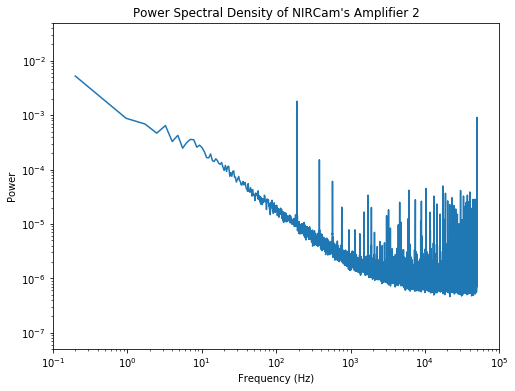

In [25]:
plt.figure(figsize=(8,6))

plt.title("Power Spectral Density of NIRCam's Amplifier 2")
plt.plot(new_frequency, np.median(powers,axis=0),zorder=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1,1e5)
plt.ylim(0.5*1e-7,0.5*1e-1)

Nice! Very same plot as Everett's.

Once again, according to this analysis, the curve seems to flatten at about $10^4$ Hz. We see various peaks like the one at 190 Hz (524 time-cycles; also seen in <a href="https://ui.adsabs.harvard.edu/abs/2011SPIE.8155E..0CR/abstract">Rauscher et al., 2011</a>), which is the largest peak in this periodogram. But, of course, the most obvious part is the 1/f component --- it goes all the way to lower frequencies!

### 3. Getting the same plot with a generic outlier-detection scheme

Here I compare the resulting power spectral density using a more "generic" outlier detection scheme. First, we need to know a typical dispersion of the data --- one good measure to do this is the <a href="https://en.wikipedia.org/wiki/Median_absolute_deviation">median-absolute deviation (MAD)</a>, which is an outlier-resistant metric to estimate the dispersion of the data. Interestingly, the MAD and the standard-deviation assuming gaussian noise have a direct linear relationship --- $\sigma = 1.4826 \times MAD $. We can use that to then remove all pixels deviating more than, say, 10 sigma from the median value. The caveat here is that the noise is _not_ white-gaussian, but 10-sigma is such a large value that this doesn't matter that much.

Let's first create a function that calculates the MAD:

In [26]:
def get_MAD_sigma(x,median):
    """
    This function returns the MAD-based standard-deviation.
    """
    mad = np.median(np.abs(x-median))
    return 1.4826*mad

All right, let's now repeat the same power-spectral density estimation as above, but considering as "good pixels" pixels which are within 10-$\sigma$ form the median, where $\sigma$ is estimated with the MAD. We plot the values of those $\sigma$'s below:

In [30]:
# We will save the new PSD in a new array:
new_powers = np.zeros([amp2.shape[0], len(new_frequency)])
# Let's also save the sigmas on each group:
sigmas = np.zeros(amp2.shape[0])
for n in range(amp2.shape[0]):
    group_median_flux = np.median(flattened_groups[n,:])
    sigma = get_MAD_sigma(flattened_groups[n,:], group_median_flux)
    sigmas[n] = sigma
    good_values = np.where(np.abs(flattened_groups[n,:] - group_median_flux)<= 10.*sigma)[0]
    new_powers[n,:] = LombScargle(times[good_values]*1e-6, flattened_groups[n,good_values]).power(new_frequency)

Text(0, 0.5, 'MAD-based $\\sigma$')

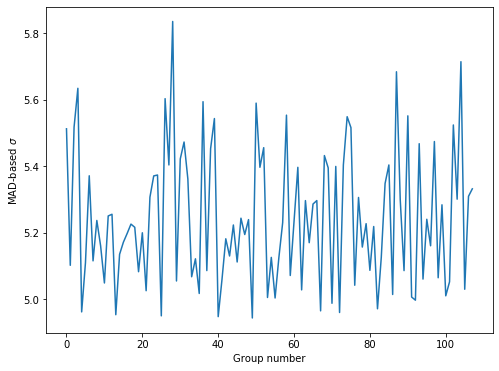

In [31]:
plt.figure(figsize=(8,6))
plt.plot(sigmas)
plt.xlabel('Group number')
plt.ylabel('MAD-based $\sigma$')

The MAD-based values of $\sigma$ are all more or less the same! Which is reasurring --- and good. Basically, its on the order of 5 --- meaning that our 10-$\sigma$ outlier rejection basically removes counts higher than about 50; very similar to the "80 cut" made by Everett.

Let's now plot the average periodogram using this outlier-detection method, and Everett's:

(5e-08, 0.05)

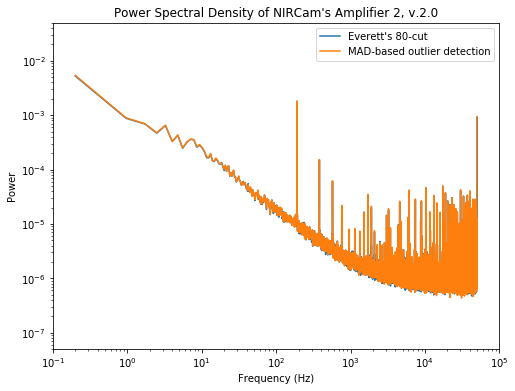

In [32]:
plt.figure(figsize=(8,6))

plt.title("Power Spectral Density of NIRCam's Amplifier 2, v.2.0")
plt.plot(new_frequency, np.median(powers,axis=0),zorder=1, label ="Everett's 80-cut")
plt.plot(new_frequency, np.median(new_powers,axis=0),zorder=1, label ="MAD-based outlier detection")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.1,1e5)
plt.ylim(0.5*1e-7,0.5*1e-1)

It is basically the same thing! This is good then; for analyses made in other instruments, we might want to use the MAD-based outlier detection, which is a bit more generic.